<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/FastText_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet
!pip install gensim==3.8.3 --quiet
!pip install compress-fasttext==0.0.1 --quiet

In [32]:
import wget
import os
import sys
import re
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import compress_fasttext
import gensim

# **Get cleaned dataset**

In [33]:
PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [34]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
3517,ого рубль прям дёшево,0
12788,можно отсертифицироваться за сч работодатель,0
10576,ну просто вязать жгут на бисерина из тут какой...,0
6798,я двадцать седьмой год работать по час любить ...,0
6393,сразу видно где современный город где деревня ...,0
1608,это тот человек который по идея должный быть ц...,1
280,это ты мерзкий же отрицать пока не стать извес...,1
3471,самый удивительный что этот критерий быть испо...,0
4117,почему магазин продать товар банк свой прибыль...,0
887,не пытаться я понять не напрягать свой зачаток...,1


In [35]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 159.97800444074383


max:  890
min:  0
mean:  24.667291146267


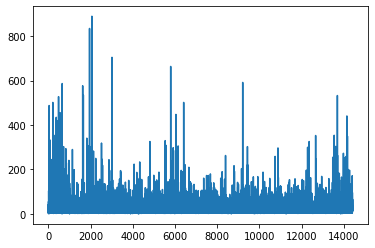

In [36]:
print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [37]:
sentences = df.comment.values
labels = df.toxic.values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941   .25

(11529,)


In [39]:
X_train.shape

(8646,)

[FastText Embedding by David Dale](https://github.com/avidale/compress-fasttext/releases/tag/v0.0.1)

In [40]:
import compress_fasttext
# url = 'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_300.bin'

# print(small_model['спасибо'])
# # [ 0.26762889  0.35489027 ...  -0.06149674] # a 300-dimensional vector
# print(small_model.most_similar('котенок'))


# import fasttext
url = 'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_300.bin'
PATH_FASTTEXT = 'ft_freqprune_100K_20K_pq_300.bin'



if not os.path.exists(PATH_FASTTEXT):
    wget.download(url)
    
# ft = fasttext.load_model('ft_freqprune_100K_20K_pq_300.bin')

ft = gensim.models.fasttext.FastTextKeyedVectors.load('ft_freqprune_100K_20K_pq_300.bin')
print(ft['jhsfbjhsg'].shape)


(300,)


In [41]:
PAD_TOKEN = '<pad>'

In [42]:
def vectorize_sentence(sentence: str, vectorizer=ft, pad_token = PAD_TOKEN, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [vectorizer.get_vector(t) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [vectorizer[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [43]:
# получить длину(количество слов) отзывов в 75% датасета
sequence_length=int(round(np.percentile(list(map(lambda sentence: len(sentence.split()), X_train)), 75)))

In [44]:
sequence_length=32
sequence_length

32

# Word Vectorizer

In [45]:
X_train = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=ft,
        pad_token = PAD_TOKEN,
        max_sequence_length=sequence_length),
    X_train.flatten()
    )
))

X_val = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=ft,
        pad_token = PAD_TOKEN,
        max_sequence_length=sequence_length),
    X_val.flatten()
    )
))

X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=ft,
        pad_token = PAD_TOKEN,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))

# X_train = np.array(list(
#     map(fasttext_sentence_vectorizer, X_train.flatten())
# ))

# X_test = np.array(list(
#     map(fasttext_sentence_vectorizer, X_test.flatten())
# ))

In [46]:
X_train.shape

(8646, 32, 300)

In [47]:
ft[PAD_TOKEN].shape[0]

300

In [48]:
DIMENSION_EMBEDDING=ft[PAD_TOKEN].shape[0]

# Build model  BiLSTM

Model: "FASTTEXT-RusVectores_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d (SpatialD  (None, 32, 300)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 32, 512)          1140736   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                       

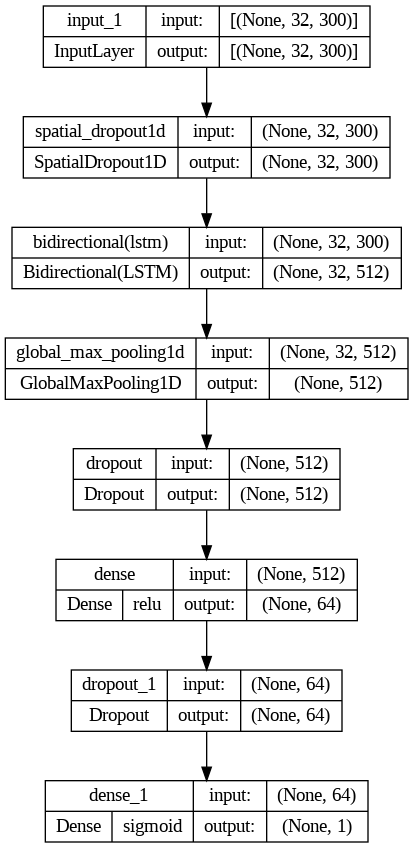

In [49]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Bidirectional,LSTM,SpatialDropout1D,GlobalMaxPool1D
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

MODEL_NAME = 'FASTTEXT-RusVectores_BiLSTM'
SEED = 42
SPLIT = 0.2
EPOCHS = 50
BATCH_SIZE = 512

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, recurrent_dropout=0.1, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [50]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/50
17/17 [==============================] - 27s 676ms/step - loss: 0.6763 - tp: 1380.0000 - fp: 1823.0000 - tn: 3911.0000 - fn: 1532.0000 - accuracy: 0.6120 - precision: 0.4308 - recall: 0.4739 - auc: 0.6076 - prc: 0.4388 - val_loss: 0.5654 - val_tp: 691.0000 - val_fp: 465.0000 - val_tn: 1443.0000 - val_fn: 284.0000 - val_accuracy: 0.7402 - val_precision: 0.5978 - val_recall: 0.7087 - val_auc: 0.8108 - val_prc: 0.7063
Epoch 2/50
17/17 [==============================] - 5s 268ms/step - loss: 0.5063 - tp: 2171.0000 - fp: 1181.0000 - tn: 4553.0000 - fn: 741.0000 - accuracy: 0.7777 - precision: 0.6477 - recall: 0.7455 - auc: 0.8355 - prc: 0.7166 - val_loss: 0.4359 - val_tp: 843.0000 - val_fp: 426.0000 - val_tn: 1482.0000 - val_fn: 132.0000 - val_accuracy: 0.8065 - val_precision: 0.6643 - val_recall: 0.8646 - val_auc: 0.9012 - val_prc: 0.8171
Epoch 3/50
17/17 [==============================] - 5s 314ms/step - loss: 0.4249 - tp: 2347.0000 - fp: 950.0000 - tn: 4784.0000 - fn: 565.0000

**Save Model**

In [51]:
model.save(MODEL_NAME)

In [52]:
pred = model.predict(X_test).flatten()

91/91 [==============================] - 3s 31ms/step


In [53]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

**Model evaluation**

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
  print("Recall:", score_to_percent(recall_score(y_test, pred)))
  print("Precision:",score_to_percent(precision_score(y_test, pred)))
  print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')
  precision, recall, f1score = precision_recall_fscore_support(y_test, pred, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(y_test, pred,digits=4))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 88.24 %
Recall: 86.47 %
Precision: 79.3 %
F1-score: 82.73 % 

precision: 0.862326225457235, recall: 0.8778481179084658, f1score: 0.8690824963373822
              precision    recall  f1-score   support

           0     0.9317    0.8909    0.9109      1944
           1     0.7930    0.8647    0.8273       939

    accuracy                         0.8824      2883
   macro avg     0.8623    0.8778    0.8691      2883
weighted avg     0.8865    0.8824    0.8836      2883

True Negatives:  1732
False Positives:  212
False Negatives:  127
True Positives:  812


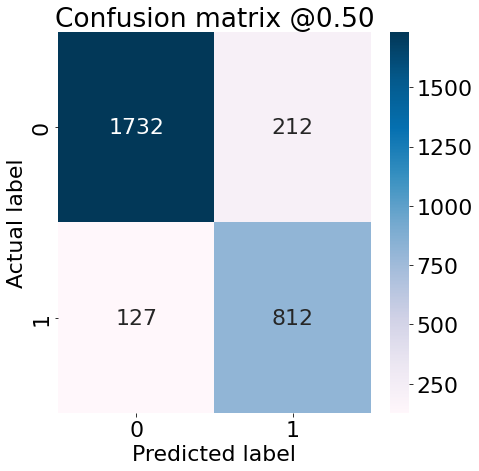

In [55]:
plot_cm(y_test, pred)

In [56]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

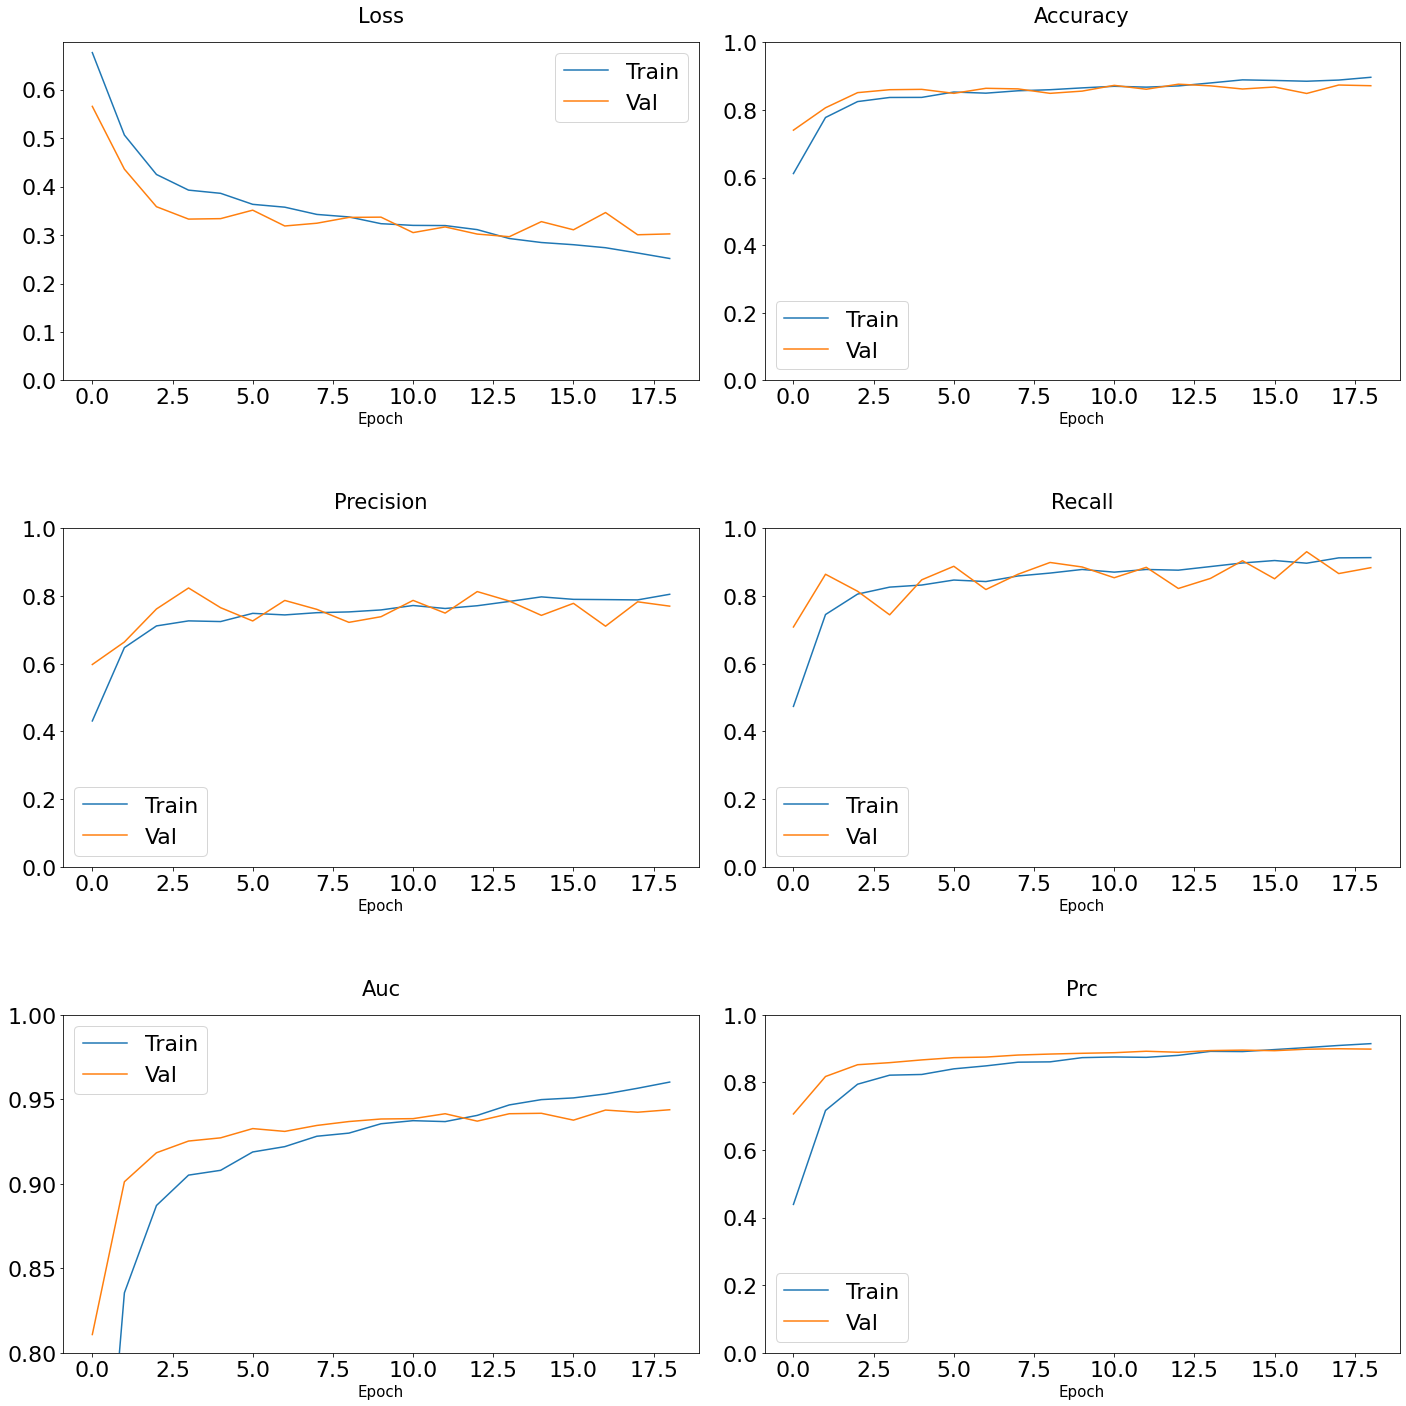

In [57]:
plot_metrics(history)